## AutoGluonImputer

This package offers a sophisticated solution for handling missing data in datasets using the AutoGluon TabularPredictor. It's adept at working with both numerical and categorical data and provides a machine-learning-driven approach for imputation.

### Import libraries

We start by loading libraries.

In [1]:
#!pip install --upgrade pandas numpy scikit-learn autogluon
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from autogluon.tabular import TabularDataset
from  import Imputer 
import importlib


ModuleNotFoundError: No module named 'autogluonImputer'

### Understanding the Imputer Class

Before we utilize the `Imputer` class for handling missing data, it's beneficial to understand its structure and functionalities. In the next cell, we'll retrieve and display the help documentation and source code for this class.


In [2]:
# get help about Imputer
help(Imputer)

# print the content of Imputer
import inspect
print(inspect.getsource(Imputer))

NameError: name 'Imputer' is not defined

#### Step 2: Prepare the Data


#### Data Preparation Overview

In this step, we load the Titanic dataset using `fetch_openml` and perform initial data preprocessing, including:
- Merging the features and target variable into a single DataFrame.
- Dropping less relevant columns like 'name' and 'ticket'.
- Displaying the first few rows of the DataFrame for a quick overview.


In [ ]:

# Load the data
X, y = fetch_openml(
    "titanic", version=1, as_frame=True, return_X_y=True, parser="pandas"
)

# combine X and y in one dataframe
df=X.copy()
df['target']=y
df.head()
# drop name and ticket

df.drop(['name','ticket'],axis=1,inplace=True)


#### Data Type Conversion

To optimize the dataset for use with the AutoGluon framework, we convert:
- String columns (object type) to categorical data types.
- Integer columns to float data types.

These conversions are necessary for the AutoGluon algorithms to process the data correctly and efficiently.


In [ ]:
df=TabularDataset(df)
df.dtypes
# convert object to category
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=df[col].astype('category')

# convert integer to float
for col in df.columns:
    if df[col].dtype=='int64':
        df[col]=df[col].astype('float64')

df.dtypes


pclass        float64
sex          category
age           float64
sibsp         float64
parch         float64
fare          float64
cabin        category
embarked     category
boat         category
body          float64
home.dest    category
target       category
dtype: object

#### Introducing Missing Values

To simulate a realistic scenario where datasets often have missing values, we artificially introduce missingness into our training and test datasets. This step allows us to demonstrate the effectiveness of the `Imputer` class in dealing with incomplete data.


In [ ]:

# Split the data into train and test sets
train, test = train_test_split(df, test_size=0.3, random_state=42)

# Introduce missingness
train_missing = train.mask(np.random.random(train.shape) < 0.2)
test_missing = test.mask(np.random.random(test.shape) < 0.2)
print(train_missing.head())


      pclass     sex   age  sibsp  parch     fare cabin embarked boat  body  \
1214     3.0     NaN   NaN    0.0    0.0   8.6625   NaN        S  NaN   NaN   
677      3.0    male  26.0    0.0    0.0   7.8958   NaN        S  NaN   NaN   
534      2.0  female  19.0    0.0    0.0      NaN   NaN        S   11   NaN   
1174     3.0  female   NaN    8.0    2.0  69.5500   NaN      NaN  NaN   NaN   
864      3.0  female   NaN    0.0    0.0   7.7750   NaN        S  NaN   NaN   

                 home.dest target  
1214                   NaN      0  
677   Bulgaria Chicago, IL    NaN  
534                    NaN    NaN  
1174                   NaN    NaN  
864                    NaN      0  


## Imputing Missing Values with AutoGluonImputer

We use the `Imputer` class to fill in the missing values in our datasets. The `Imputer` is configured and then applied to both the training and test datasets to perform imputation. The settings for the number of iterations (`num_iter`) and time limit (`time_limit`) are adjustable parameters that control the imputation process.


In [ ]:
imputer = Imputer(num_iter=2, time_limit=5)
train_imputed = imputer.fit(train_missing)
test_imputed = imputer.transform(test_missing)


No path specified. Models will be saved in: "AutogluonModels/ag-20240828_214309/"
		_format_eval_result() missing 1 required positional argument: 'show_stdv'
		_format_eval_result() missing 1 required positional argument: 'show_stdv'
		_format_eval_result() missing 1 required positional argument: 'show_stdv'
		_format_eval_result() missing 1 required positional argument: 'show_stdv'
No path specified. Models will be saved in: "AutogluonModels/ag-20240828_214314/"
		_format_eval_result() missing 1 required positional argument: 'show_stdv'
		_format_eval_result() missing 1 required positional argument: 'show_stdv'
		'Booster' object has no attribute 'best_ntree_limit'
		_format_eval_result() missing 1 required positional argument: 'show_stdv'
No path specified. Models will be saved in: "AutogluonModels/ag-20240828_214320/"
		_format_eval_result() missing 1 required positional argument: 'show_stdv'
		_format_eval_result() missing 1 required positional argument: 'show_stdv'
		_format_eval_

### Evaluating Imputation Quality

To assess the quality of the imputed values, we focus on the 'age' feature in the test dataset:
- We plot the imputed values against the original values.
- A scatter plot with a regression line helps visualize the accuracy of the imputation.
- We calculate the correlation coefficient between the imputed and original values to quantify the imputation accuracy.


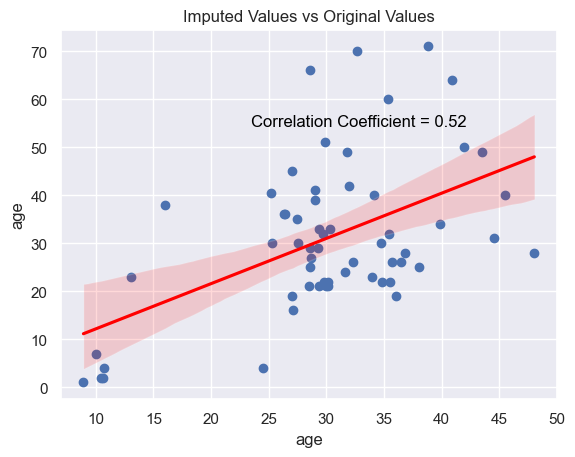

In [ ]:
# Compare imputed values with original values for the target variable
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# Identify missing indices in test dataset
missing_indices_test = test_missing['age'].index[test_missing['age'].apply(np.isnan)]

# Plot imputed values against original values
plt.scatter(test_imputed['age'][missing_indices_test], test['age'][missing_indices_test])
plt.xlabel('Imputed Values')
plt.ylabel('Original Values')
plt.title('Imputed Values vs Original Values')
sns.regplot(x=test_imputed['age'][missing_indices_test], y=test['age'][missing_indices_test], scatter=False, color='red')
# Calculate and display the correlation coefficient
# put test_imputed['age'][missing_indices_test], test['age'][missing_indices_test] in a dataframe
df=pd.DataFrame({'imputed':test_imputed['age'][missing_indices_test], 'original':test['age'][missing_indices_test]})
# remove rows with missing values
df=df.dropna()
# calculate correlation coefficient
corr = np.corrcoef(df['imputed'], df['original'])[0,1]
plt.text(.6, .75, f'Correlation Coefficient = {round(corr, 2)}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='black')
plt.show()

### Preview of Imputed Test Data

To get a sense of the results of the imputation, we preview the first few rows of the imputed test dataset. This helps in visually assessing the changes and imputations made by the `Imputer` class.


In [ ]:
test_imputed.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,home.dest,target
1148,3.0,male,35.000000,0.0,0.0,7.125000,D56,S,13,111.847786,London,0
1049,3.0,female,20.000000,1.0,1.0,15.741700,G6,C,13,116.761307,"Ireland Chicago, IL",1
982,3.0,male,38.273453,0.0,0.0,14.416011,D56,S,13,105.045563,London,0
808,3.0,male,29.006245,0.0,0.0,8.050000,F38,S,13,80.359222,"Bridgwater, Somerset, England",0
1195,3.0,male,27.336069,0.0,0.0,7.750000,F38,Q,13,102.126579,Ireland,0


### Evaluating the Imputation Method

The `Imputer` class provides an `evaluate_imputation` method to assess the effectiveness of the imputation. This function simulates missingness in the data, imputes the values, and then compares the imputed values against the original data. It provides a quantitative measure of the imputation's accuracy.


In [ ]:
imputer.evaluate_imputation(train, percentage=.2, ntimes=3)


{0: {'pclass': {'mse': 0.47540983606557374, 'mae': 0.3989071038251366},
  'sex': {'accuracy': 0.8087431693989071},
  'age': {'mse': 135.04832658968996, 'mae': 9.011827822229984},
  'sibsp': {'mse': 0.819672131147541, 'mae': 0.44808743169398907},
  'parch': {'mse': 0.7540983606557377, 'mae': 0.28415300546448086},
  'fare': {'mse': 2470.1314116123585, 'mae': 18.859409294526657},
  'cabin': {'accuracy': 0.6046511627906976},
  'embarked': {'accuracy': 0.6557377049180327},
  'boat': {'accuracy': 0.25},
  'body': {'mse': 9000.552620462218, 'mae': 74.30204831636868},
  'home.dest': {'accuracy': 0.32456140350877194},
  'target': {'accuracy': 0.7978142076502732}},
 1: {'pclass': {'mse': 0.3989071038251366, 'mae': 0.366120218579235},
  'sex': {'accuracy': 0.7377049180327869},
  'age': {'mse': 138.82512830044277, 'mae': 9.164554215574613},
  'sibsp': {'mse': 0.726775956284153, 'mae': 0.3333333333333333},
  'parch': {'mse': 0.9234972677595629, 'mae': 0.2677595628415301},
  'fare': {'mse': 2698.654

In [ ]:
imputer.evaluate_imputation(test, percentage=.2, ntimes=3)


{0: {'pclass': {'mse': 0.44871794871794873, 'mae': 0.4230769230769231},
  'sex': {'accuracy': 0.8333333333333334},
  'age': {'mse': 241.34975193797402, 'mae': 12.231708978542205},
  'sibsp': {'mse': 1.3974358974358974, 'mae': 0.47435897435897434},
  'parch': {'mse': 0.2692307692307692, 'mae': 0.19230769230769232},
  'fare': {'mse': 811.7481002697948, 'mae': 16.081680093667444},
  'cabin': {'accuracy': 0.05555555555555555},
  'embarked': {'accuracy': 0.5128205128205128},
  'boat': {'accuracy': 0.1},
  'body': {'mse': 11262.196927607234, 'mae': 80.75908660888672},
  'home.dest': {'accuracy': 0.14},
  'target': {'accuracy': 0.8205128205128205}},
 1: {'pclass': {'mse': 0.28205128205128205, 'mae': 0.28205128205128205},
  'sex': {'accuracy': 0.7948717948717948},
  'age': {'mse': 167.8513572021792, 'mae': 10.302638069528047},
  'sibsp': {'mse': 0.5512820512820513, 'mae': 0.3974358974358974},
  'parch': {'mse': 0.44871794871794873, 'mae': 0.2948717948717949},
  'fare': {'mse': 2344.05238107722

# Multiple Imputation

Multiple imputation is a statistical technique used to handle missing data by creating multiple complete datasets. Each dataset is imputed separately, and the results are typically pooled for analysis. This approach accounts for the uncertainty associated with imputation, often leading to more robust and reliable statistical inferences.


In [ ]:
from scripts.autogluonImputer import multiple_imputation
num_iter=2
time_limit=10
train_imputed = multiple_imputation(train_missing, n_imputations=10, num_iter=num_iter, time_limit=time_limit, fitonce=True)


No path specified. Models will be saved in: "AutogluonModels/ag-20240828_214541/"
		Target -1 is out of bounds.
		_format_eval_result() missing 1 required positional argument: 'show_stdv'
		_format_eval_result() missing 1 required positional argument: 'show_stdv'
		catboost/private/libs/algo/data.cpp:196: Dataset test #0 contains class label "12" that is not present in the learn dataset
		Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109], got [  0   1   2   3   4   5   6   7   8  13  14  17  18  19  20  21  23  24
  25  27  28  29  3

In [ ]:
train_imputed[0].head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,home.dest,target
1214,3.0,male,29.576599,0.0,0.0,8.662500,F G63,S,13,86.393333,"Oslo, Norway Cameron, WI",0
677,3.0,male,26.000000,0.0,0.0,7.895800,F G63,S,13,134.823334,"Bulgaria Chicago, IL",0
534,2.0,female,19.000000,0.0,0.0,15.103352,F33,S,11,72.963333,"Cornwall / Hancock, MI",1
1174,3.0,female,10.898613,8.0,2.0,69.550000,G6,S,2,79.870003,"Wiltshire, England Niagara Falls, NY",0
864,3.0,female,30.493999,0.0,0.0,7.775000,F33,S,13,81.033333,"Aughnacliff, Co Longford, Ireland New York, NY",0


In [ ]:
train_imputed[1].head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,home.dest,target
1214,3.0,male,27.177311,0.0,0.0,8.662500,F G63,S,13,121.110001,"Oslo, Norway Cameron, WI",0
677,3.0,male,26.000000,0.0,0.0,7.895800,F G63,S,13,134.823334,"Bulgaria Chicago, IL",0
534,2.0,female,19.000000,0.0,0.0,13.929872,F33,S,11,74.553337,"Cornwall / Hancock, MI",1
1174,3.0,female,10.741144,8.0,2.0,69.550000,G6,S,9,92.303337,"Wiltshire, England Niagara Falls, NY",0
864,3.0,female,33.725178,0.0,0.0,7.775000,F33,S,13,61.776669,"Aughnacliff, Co Longford, Ireland New York, NY",0


In [ ]:
train_imputed[1].dtypes

pclass        float64
sex          category
age           float64
sibsp         float64
parch         float64
fare          float64
cabin        category
embarked     category
boat         category
body          float64
home.dest    category
target       category
dtype: object